<center>
  <img src="https://digip.unibg.it/sites/dip3/files/logo-dip-it.svg">
  <h1><b>Crash course in Python </b> - AA 2024/2025</h1>
  <h2>Lezione 3 - Caso di studio ✏️</h2>
  <h3>A cura di <a href="https://github.com/lamferzon?tab=repositories">Lorenzo Leoni</a></h3>
</center>

# Importazione dei pacchetti 📄

In [253]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

# Importazione dei dati 💾

In [254]:
data = pd.read_csv("phone_data.csv")

# rinominazione delle colonne
data = data.rename(
    columns={col_i: col_i.lower().replace(" ", "_") for col_i in data.columns}
)

# alcune informazioni riguardanti il dataset
nrows, ncols = data.shape
print(f"Dimensioni del dataset \n- Numero di righe: {nrows}.\n- Numero di colonne: {ncols}.")
print("\nColonne del dataset e rispettivi tipi")
for col_i in data.columns:
    print(f"- {col_i.capitalize()} ({data[col_i].dtype}).")

Dimensioni del dataset 
- Numero di righe: 1715.
- Numero di colonne: 31.

Colonne del dataset e rispettivi tipi
- Phone_brand (object).
- Phone_model (object).
- Store (object).
- Price (float64).
- Currency (object).
- Price_usd (float64).
- Storage (int64).
- Ram (int64).
- Launch (object).
- Dimensions (object).
- Weight (float64).
- Display_type (object).
- Display_size (float64).
- Display_resolution (object).
- Os (object).
- Nfc (int64).
- Usb (object).
- Battery (int64).
- Features_sensors (object).
- Colors (object).
- Video (object).
- Chipset (object).
- Cpu (object).
- Gpu (object).
- Year (int64).
- Foldable (int64).
- Ppi_density (int64).
- Quantile_10 (object).
- Quantile_50 (float64).
- Quantile_90 (object).
- Price_range (object).


# Elaborazione preliminare 🔧

## Rimozione delle colonne superflue o ad alta cardinalità

In [255]:
print("Cardinalità delle colonne categoriche")
for col_i in data.columns:
    if data[col_i].dtype == object:
        print(f"- {col_i.capitalize()}: {len(data[col_i].unique())}.")

data = data.drop(
    columns=[
        "phone_model",
        "price",
        "currency",
        "launch",
        "display_type",
        "display_resolution",
        "os",
        "usb",
        "features_sensors",
        "colors",
        "video",
        "gpu",
        "quantile_10",
        "quantile_50",
        "quantile_90",
        # "price_range"
    ]
)

Cardinalità delle colonne categoriche
- Phone_brand: 22.
- Phone_model: 472.
- Store: 8.
- Currency: 3.
- Launch: 337.
- Dimensions: 397.
- Display_type: 262.
- Display_resolution: 68.
- Os: 213.
- Usb: 35.
- Features_sensors: 63.
- Colors: 416.
- Video: 164.
- Chipset: 158.
- Cpu: 128.
- Gpu: 76.
- Quantile_10: 8.
- Quantile_90: 8.
- Price_range: 3.


## Creazione della colonna `volume`

In [256]:
def get_volume(row):
    match = re.findall(r"([\d.]+) x ([\d.]+) x ([\d.]+) mm", row.dimensions)
    if match:
        height, width, thickness = match[0]
        return round(float(height)*float(width)*float(thickness), 2)
    else:
        None
data["volume"] = data.apply(get_volume, axis=1)

# rimozione della colonna "dimensions" e dei dati mancanti
data = data.drop(
    columns=[
        "dimensions"
    ]
).dropna().reset_index(drop=True)

## Creazione della colonna `chipset_brand`

In [257]:
def get_chipset_brand(row):
    return row.chipset.split()[0]
data["chipset_brand"] = data.apply(get_chipset_brand, axis=1)

## Creazione della colonna `chipset_production_process`

In [258]:
def get_chipset_production_process(row):
    match = re.search(r"\((\d+)\s*nm\)", row.chipset)
    if match:
        return int(match.group(1))
    else:
        None
data["chipset_production_process"] = data.apply(get_chipset_production_process, axis=1)

# rimozione della colonna "chipset" e dei dati mancanti
data = data.drop(
    columns=[
        "chipset"
    ]
).dropna().reset_index(drop=True)

## Creazione della colonna `cpu_cores`

In [259]:
core_map = {
    'Hexa': 6,
    'Octa': 8,
    'Quad': 4,
    'Nona': 9,
    'Deca': 10,
    'Dual': 2
}

def get_cpu_cores(row):
    
    # primo passa: ricerca dei prefissi come "Hexa", "Octa", "Quad", etc.
    for key, value in core_map.items():
        if key.lower() in row.cpu.lower():
            return int(value)
    
    # secondo passo: utilizzo di un'espressione regolare (regex) per cercare numeri seguiti da "-core"
    match = re.search(r'(\d+)-core', row.cpu, re.IGNORECASE)
    if match:
        return int(match.group(1))
    else:
        return None

data["cpu_cores"] = data.apply(get_cpu_cores, axis=1)

# rimozione della colonna "cpu" e dei dati mancanti
data = data.drop(
    columns=[
        "cpu"
    ]
).dropna().reset_index(drop=True)

## Conversione di tipo delle colonne `nfc`, `foldable` e `year`

In [260]:
data["phone_brand"] = data.phone_brand.str.capitalize()
data["nfc"] = data.nfc.replace(1, "Yes").replace(0, "Not")
data["foldable"] = data.foldable.replace(1, "Yes").replace(0, "Not")
data["year"] = data.year.astype(str)

## DataFrame dopo il processamento iniziale

In [261]:
data.sort_index(axis=1).sort_values(by="price_usd", ascending=False).head(10)

,battery,chipset_brand,chipset_production_process,cpu_cores,display_size,foldable,nfc,phone_brand,ppi_density,price_range,price_usd,ram,storage,store,volume,weight,year
1073,4800,Qualcomm,4.0,8.0,7.85,Yes,Yes,Huawei,426,high price,2361.66,12,512,Amazon DE,117667.16,239.0,2023
1573,4650,Google,4.0,8.0,8.00,Yes,Yes,Google,373,high price,2275.45,16,512,Amazon UK,118886.30,257.0,2024
1534,5150,Qualcomm,4.0,8.0,7.92,Yes,Yes,Honor,402,high price,2197.39,12,512,Amazon UK,98979.81,226.0,2024
1533,5150,Qualcomm,4.0,8.0,7.92,Yes,Yes,Honor,402,high price,2122.77,12,512,Amazon DE,98979.81,226.0,2024
1571,4650,Google,4.0,8.0,8.00,Yes,Yes,Google,373,high price,2049.08,16,512,Amazon DE,118886.30,257.0,2024
1549,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,374,high price,2028.26,12,1000,Amazon UK,113982.96,239.0,2024
1546,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,374,high price,2019.99,12,1000,Best Buy,113982.96,239.0,2024
1536,4780,Qualcomm,4.0,8.0,6.86,Yes,Yes,Xiaomi,460,high price,1999.00,12,512,AliExpress,94202.00,190.0,2024
1187,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,373,high price,1919.99,12,1000,Samsung,122741.21,253.0,2023
768,4400,Qualcomm,4.0,8.0,7.60,Yes,Yes,Samsung,373,high price,1919.99,12,1000,Best Buy,127124.61,263.0,2022


# Analisi preliminare 🔬

## Analisi del prezzo di vendita


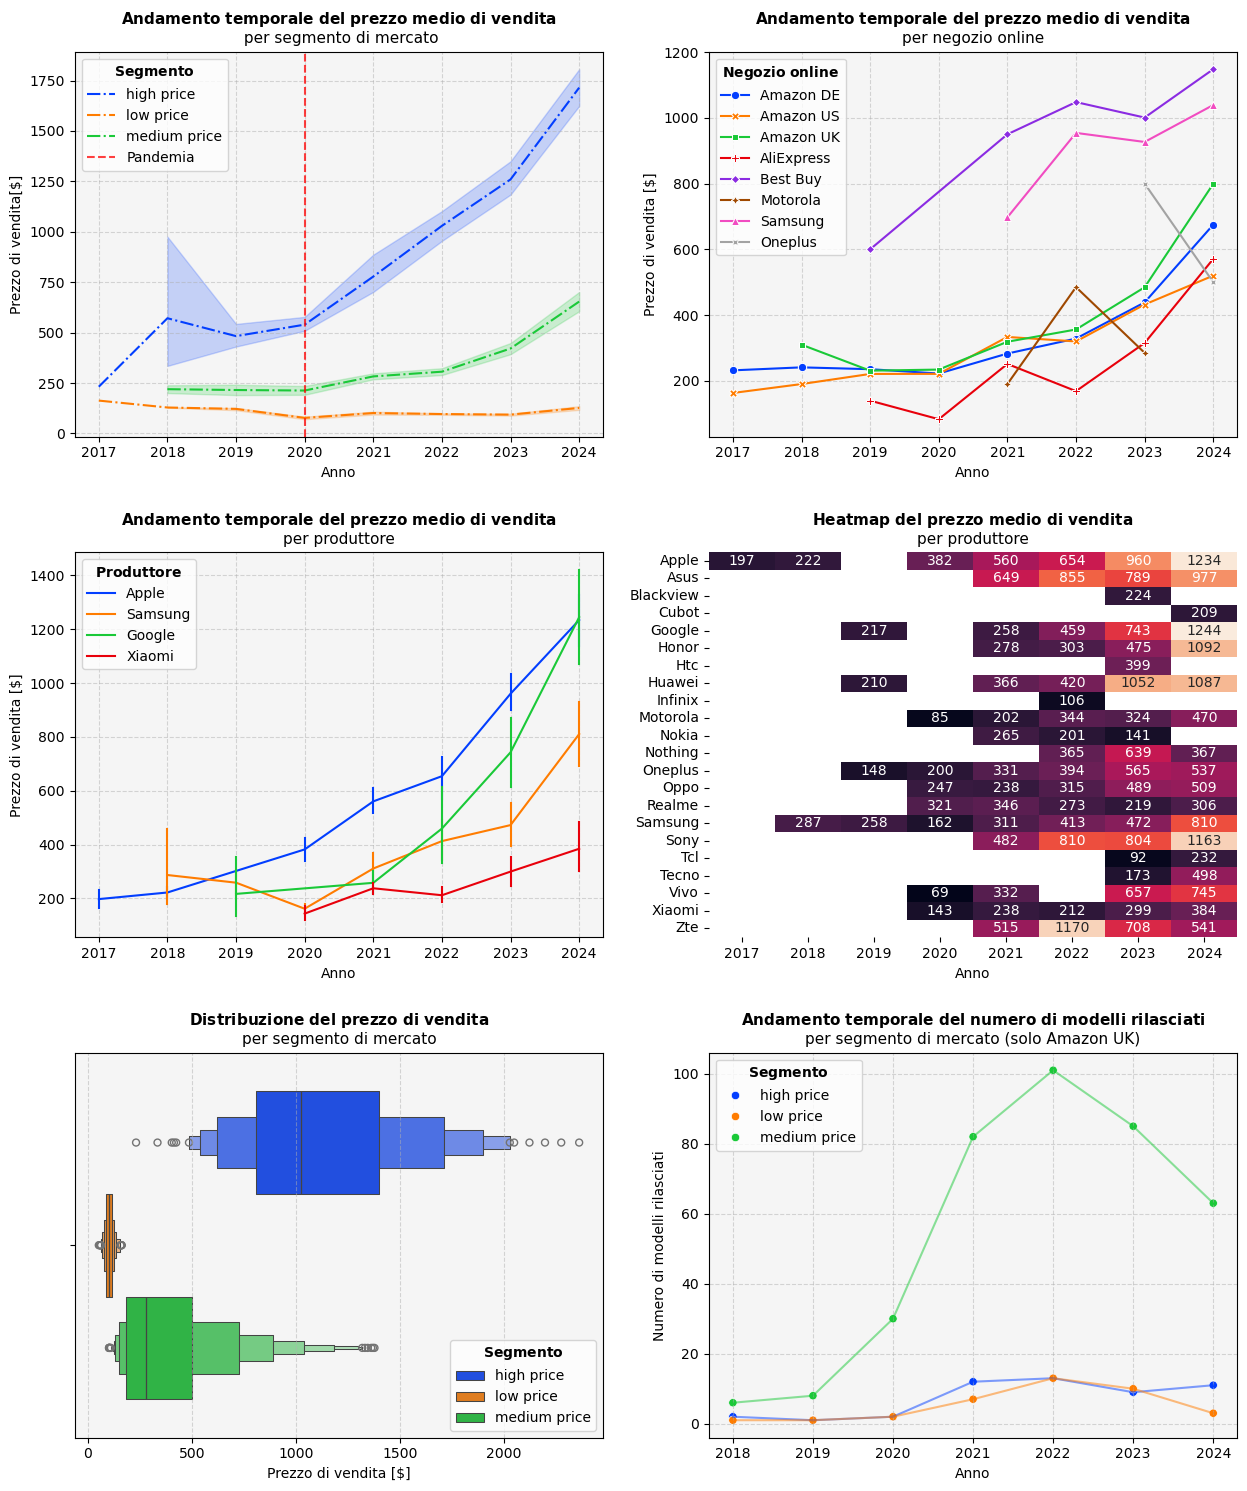

In [332]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=3,
    figsize=(15, 18)
)
fig.subplots_adjust(
    wspace=.2,
    hspace=.3
)

# andamento temporale del prezzo medio, per segmento di mercato
sns.lineplot(
    data=data,
    x="year",
    y="price_usd",
    ls="-.",
    hue="price_range",
    palette="bright",
    ax=axes[0, 0]
)
axes[0, 0].axvline(
    "2020",
    color="red",
    ls="--",
    alpha=.75,
    label="Pandemia"
)
axes[0, 0].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ prezzo \\ medio \\ di \\ vendita}$\n per segmento di mercato",
    size=11
)
axes[0, 0].set(
    xlabel="Anno",
    ylabel="Prezzo di vendita[$]",
    facecolor="whitesmoke"
)
axes[0, 0].grid(
    ls="--",
    alpha=.5
)
axes[0, 0].legend(
    title="$\\mathbf{Segmento}$"
)

# andamento temporale del prezzo medio, per negozio online
sns.lineplot(
    data=data,
    x="year",
    y="price_usd",
    hue="store",
    style="store",
    palette="bright",
    err_style=None,
    markers=True,
    dashes=False,
    ax=axes[0, 1]
)
axes[0, 1].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ prezzo \\ medio \\ di \\ vendita}$\nper negozio online",
    size=11
)
axes[0, 1].set(
    xlabel="Anno",
    ylabel="Prezzo di vendita [$]",
    facecolor="whitesmoke"
)
axes[0, 1].grid(
    ls="--",
    alpha=.5
)
axes[0, 1].legend(
    title="$\\mathbf{Negozio \\ online}$"
)

# andamento temporale del prezzo medio, per produttore
sns.lineplot(
    data=data[
        (data.phone_brand == "Samsung") | 
        (data.phone_brand == "Google") |
        (data.phone_brand == "Apple") |
        (data.phone_brand == "Xiaomi")
    ],
    x="year",
    y="price_usd",
    hue="phone_brand",
    palette="bright",
    err_style="bars",
    ax=axes[1, 0]
)
axes[1, 0].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ prezzo \\ medio \\ di \\ vendita}$\nper produttore",
    size=11
)
axes[1, 0].set(
    xlabel="Anno",
    ylabel="Prezzo di vendita [$]",
    facecolor="whitesmoke"
)
axes[1, 0].grid(
    ls="--",
    alpha=.5
)
axes[1, 0].legend(
    title="$\\mathbf{Produttore}$"
)

# heatmap del prezzo medio di vendita, per produttore
sns.heatmap(
    data.pivot_table(
        index="phone_brand",
        columns="year",
        values="price_usd",
        aggfunc="mean"
    ),
    annot=True,
    fmt=f".0f",
    cbar=False,
    ax=axes[1, 1]
)
axes[1, 1].set_title(
    "$\\mathbf{Heatmap\\ del \\ prezzo \\ medio \\ di \\ vendita}$\nper produttore",
    size=11
)
axes[1, 1].set(
    xlabel="Anno",
    ylabel=None
)

# distribuzione del prezzo medio, per segmento di mercato
sns.boxenplot(
    data=data,
    x="price_usd",
    hue="price_range",
    palette="bright",
    ax=axes[2, 0]
)
axes[2, 0].set_title(
    "$\\mathbf{Distribuzione \\ del \\ prezzo \\ di \\ vendita}$\nper segmento di mercato",
    size=11
)
axes[2, 0].set(
    xlabel="Prezzo di vendita [$]",
    facecolor="whitesmoke"
)
axes[2, 0].grid(
    axis="x",
    ls="--",
    alpha=.5
)
axes[2, 0].legend(
    title="$\\mathbf{Segmento}$"
)

# andamento temporale del numero di modelli rilasciati, per segmento di metcato (solo Amazon UK)
sns.lineplot(
    data=data[data["store"] == "Amazon UK"].groupby(["year", "price_range"]).agg(count=("price_range", "count")).reset_index(),
    x="year",
    y="count",
    hue="price_range",
    palette="bright",
    alpha=.5,
    legend=False,
    ax=axes[2, 1]
)
sns.scatterplot(
    data=data[data["store"] == "Amazon UK"].groupby(["year", "price_range"]).agg(count=("price_range", "count")).reset_index(),
    x="year",
    y="count",
    hue="price_range",
    palette="bright",
    ax=axes[2, 1]
)
axes[2, 1].set_title(
    "$\\mathbf{Andamento \\ temporale \\ del \\ numero \\ di \\ modelli \\ rilasciati}$\nper segmento di mercato (solo Amazon UK)",
    size=11
)
axes[2, 1].set(
    xlabel="Anno",
    ylabel="Numero di modelli rilasciati",
    facecolor="whitesmoke"
)
axes[2, 1].grid(
    ls="--",
    alpha=.5
)
axes[2, 1].legend(
    title="$\\mathbf{Segmento}$"
);

<Axes: xlabel='year', ylabel='phone_brand'>

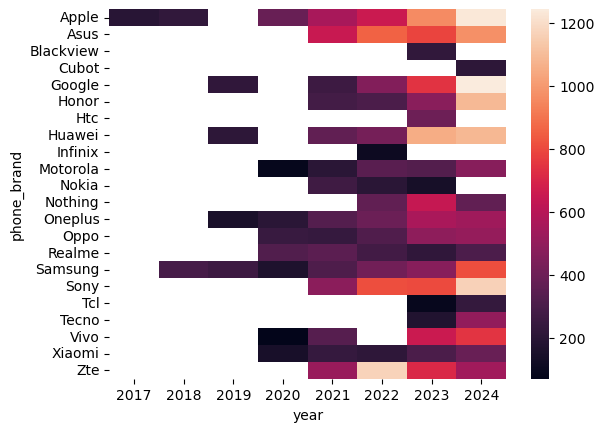

In [327]:
sns.heatmap(data.pivot_table(
        index="phone_brand",
        columns="year",
        values="price_usd",
        aggfunc="mean"
    )
)